In [24]:
import os
from typing import TypedDict, Annotated, Literal
from langgraph.graph import StateGraph, END
from langchain_google_genai import ChatGoogleGenerativeAI
import pandas as pd
from langgraph.types import interrupt, Command
import random
from datetime import datetime

In [25]:
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()


True

In [26]:
from langchain.callbacks.base import BaseCallbackHandler

class GeminiLogger(BaseCallbackHandler):
    """Custom callback handler to log Gemini model interactions"""
    
    def __init__(self, verbose=True):
        """Initialize the logger"""
        self.verbose = verbose
        
    def on_llm_start(self, serialized, prompts, **kwargs):
        """Log when LLM starts processing"""
        if self.verbose:
            print(f"\n{'='*50}")
            print(f"SENDING PROMPT TO GEMINI:")
            print(f"{'='*50}")
            for i, prompt in enumerate(prompts):
                print(f"{prompt}\n")
    
    def on_llm_end(self, response, **kwargs):
        """Log when LLM completes processing"""
        if self.verbose:
            print(f"\n{'='*50}")
            print(f"RECEIVED RESPONSE FROM GEMINI:")
            print(f"{'='*50}")
            print(f"{response.generations[0][0].text}")
            
    def on_llm_error(self, error, **kwargs):
        """Log any errors during LLM processing"""
        print(f"\n{'='*50}")
        print(f"ERROR DURING LLM CALL:")
        print(f"{'='*50}")
        print(f"Error: {error}")


In [27]:
# Define state structure
class ARWorkflowState(TypedDict):
    customer_data: dict
    order_data: dict
    policy_content: str
    credit_assessment: dict
    approval_status: Annotated[str, "approved|rejected|escalated"]
    decision_reason: str
    requires_human: bool

In [28]:
# Initialize the logger
gemini_logger = GeminiLogger()

# Initialize the model with the logger
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-001", 
    temperature=0,
    callbacks=[gemini_logger]  # Add logger to callbacks
)


In [29]:
def load_policy() -> str:
    """Load and preprocess credit policy document"""
    try:
        with open("CreditPolicy.txt", "r") as f:
            return f.read()
    except FileNotFoundError:
        return "DEFAULT_CREDIT_POLICY: Max credit utilization 80%, Min credit score 650"

In [69]:
def data_loader(state: ARWorkflowState) -> ARWorkflowState:
    """Step 1: Load customer and order data"""
    try:
        # Load CSV files
        customer_df = pd.read_csv("customer_master.csv")
        order_df = pd.read_csv("sales_order.csv")
        
        # For testing purposes, use a consistent sample rather than random
        customer_ids = list(set(order_df.Customer_ID.to_list()) & set(customer_df.Customer_ID.to_list()))
        
        if not customer_ids:
            raise ValueError("No matching customers found between datasets")
            
        customer_id = random.choice(customer_ids)  # Choose first one for consistency
        
        # Get single row and convert to dictionary (properly)
        order_row = order_df[order_df.Customer_ID == customer_id].iloc[0]
        customer_row = customer_df[customer_df.Customer_ID == customer_id].iloc[0]
        
        # Convert to proper dictionaries
        current_order = {col: order_row[col] for col in order_df.columns}
        customer_data = {col: customer_row[col] for col in customer_df.columns}
        
        print(f"Loaded data for customer: {customer_id}")
        
        return {
            **state,
            "customer_data": customer_data,
            "order_data": current_order,
            "policy_content": load_policy()
        }
    except Exception as e:
        print(f"Error loading data: {e}")
        # Return default state with error information
        return {
            **state,
            "customer_data": {"error": str(e)},
            "order_data": {"error": str(e)},
            "policy_content": load_policy(),
            "decision_reason": f"Error loading data: {e}"
        }


In [31]:
from langchain_core.output_parsers.json import JsonOutputParser
from pydantic import BaseModel, Field

# Define the Pydantic model for the expected JSON output
class CreditAssessmentModel(BaseModel):
    analysis: str = Field(description="Detailed credit assessment")
    within_limits: bool = Field(description="Whether the order is within credit limits")
    needs_escalation: bool = Field(description="Whether the order needs escalation")

In [32]:
def credit_assessment(state: ARWorkflowState) -> ARWorkflowState:
    """Step 3: Automated credit check with structured JSON output"""
    try:
        print("\nSTARTING CREDIT ASSESSMENT")
        
        # Extract key data
        customer = state.get("customer_data", {})
        order = state.get("order_data", {})
        policy = state.get("policy_content", "")
        
        # Get numeric values for reference
        credit_limit = float(customer.get("Credit_Limit", 0))
        outstanding_balance = float(customer.get("Outstanding_Balance", 0))
        order_amount = float(order.get("turnover", 0))
        available_credit = credit_limit - outstanding_balance
        
        # Initialize the JSON output parser with the Pydantic model
        json_parser = JsonOutputParser(pydantic_object=CreditAssessmentModel)
        
        # Get the format instructions
        format_instructions = json_parser.get_format_instructions()
        
        # Prepare the prompt with format instructions
        prompt = f"""
        You are a CA in accounts receivable team working for credit risk management.
        
        You have the following credit policy:
        {policy}
        
        Customer Information:
        - Credit Limit: ${credit_limit}
        - Outstanding Balance: ${outstanding_balance}
        - Available Credit: ${available_credit}
        
        Order Information:
        - Order Amount: ${order_amount}
        
        Based on this information, analyze the customer's creditworthiness.
        
        {format_instructions}
        """
        
        print("Sending request to Gemini...")
        response = model.invoke(prompt)
        print("Received response from Gemini")
        
        # Parse the JSON output
        parsed_output = json_parser.parse(response.content)
        print(f"Parsed JSON output: {parsed_output}")
        
        # Create assessment dictionary using LLM's JSON output
        assessment = {
            "analysis": parsed_output.get("analysis"),
            "available_credit": available_credit,  # Keep calculated value for reference
            "order_amount": order_amount,          # Keep calculated value for reference
            "within_limits": parsed_output.get("within_limits"),
            "needs_escalation": parsed_output.get("needs_escalation")
        }
        
        print(f"Final assessment: {assessment}")
        
        return {
            **state,
            "credit_assessment": assessment
        }
    except Exception as e:
        print(f"ERROR in credit assessment: {e}")
        import traceback
        traceback.print_exc()
        
        return {
            **state,
            "credit_assessment": {
                "analysis": f"Error in credit assessment: {e}",
                "within_limits": False,
                "needs_escalation": True
            }
        }


In [33]:
def credit_assessment(state: ARWorkflowState) -> ARWorkflowState:
    """Step 3: Automated credit check"""
    try:
        print("\nSTARTING CREDIT ASSESSMENT")
        
        # Extract key data with logging
        customer = state.get("customer_data", {})
        order = state.get("order_data", {})
        print(f"Customer data keys: {list(customer.keys())}")
        print(f"Order data keys: {list(order.keys())}")
        
        # Get numeric values with safe defaults and logging
        try:
            credit_limit = float(customer.get("Credit_Limit", 0))
            outstanding_balance = float(customer.get("Outstanding_Balance", 0))
            order_amount = float(order.get("turnover", 0))
            policy_content = state.get("policy_content", "")
            print(f"Parsed values: Credit Limit=${credit_limit}, Outstanding=${outstanding_balance}, Order=${order_amount}")
        except ValueError as e:
            print(f"ERROR converting values to float: {e}")
            raise
        
        # Prepare and send prompt to LLM
        print("\nPreparing LLM prompt...")
        prompt = f"""
        Your a CA in accounts receivable team and you are working for a credit risk management team,.
        You are responsible for assessing the creditworthiness of customers based on company policy and customers credit limit, outstanding balance, and order amount.
        You have access to a credit policy document that outlines the criteria for credit approval: 
        Policy: {policy_content}.

        Analyze this customer's creditworthiness based on the following:
        
        Customer Information:
        - Credit Limit: ${credit_limit}
        - Outstanding Balance: ${outstanding_balance}
        
        Order Information:
        - Order Amount: ${order_amount}
        
        FORMAT YOUR RESPONSE EXACTLY LIKE THIS:
        ANALYSIS: [detailed assessment]
        WITHIN_LIMITS: [Yes/No]
        NEEDS_ESCALATION: [Yes/No]
        """
        
        print("Sending request to Gemini...\n")
        response = model.invoke(prompt)
        print("Received response from Gemini\n")
        
        # Parse response
        content = response.content
        print(f"PARSING RESPONSE:\n{content}")
        
        # Create assessment with parsed results
        assessment = {
            "analysis": content,
            "available_credit": credit_limit - outstanding_balance,
            "order_amount": order_amount,
            "within_limits": (credit_limit - outstanding_balance) >= order_amount,
            "needs_escalation": (credit_limit - outstanding_balance) < order_amount
        }
        
        print(f"Final assessment: {assessment}")
        
        return {
            **state,
            "credit_assessment": assessment
        }
    except Exception as e:
        print(f"ERROR in credit assessment: {e}")
        import traceback
        traceback.print_exc()
        
        return {
            **state,
            "credit_assessment": {
                "analysis": f"Error in credit assessment: {e}",
                "within_limits": False,
                "needs_escalation": True
            }
        }


In [34]:
def policy_check(state: ARWorkflowState) -> ARWorkflowState:
    """Step 4: Policy compliance verification"""
    try:
        assessment = state.get("credit_assessment", {})
        
        print(f"Policy check assessment data: {assessment}")
        
        # Default reason if assessment is empty
        if not assessment:
            reason = "Order rejected due to missing credit assessment data"
            status = "rejected"
        elif not assessment.get("within_limits", False):
            reason = f"Order amount (${assessment.get('order_amount', 0)}) exceeds available credit (${assessment.get('available_credit', 0)})"
            status = "rejected"
        else:
            reason = "Order is within credit limits and complies with policy"
            status = "approved"
        
        print(f"Policy decision: {status} - {reason}")
        
        return {
            **state,
            "approval_status": status,
            "decision_reason": reason,
            "requires_human": assessment.get("needs_escalation", False)
        }
    except Exception as e:
        print(f"Error in policy check: {e}")
        return {
            **state,
            "approval_status": "rejected",
            "decision_reason": f"Error in policy check: {e}",
            "requires_human": True
        }


In [35]:
def human_review(state: ARWorkflowState) -> Command[Literal["approve", "reject"]]:
    """Step 4: Human escalation point"""
    review_data = {
        "customer": state["customer_data"]["Customer_ID"],
        "order_value": state["order_data"]["turnover"],
        "available_credit": state["customer_data"]["Credit_Limit"] - state["customer_data"]["Outstanding_Balance"],
        "reason": state["decision_reason"]
    }
    
    decision = interrupt(review_data)
    return Command(goto="approve" if decision else "reject")

In [36]:
# Define all node functions before creating the graph
def approve_order(state: ARWorkflowState) -> ARWorkflowState:
    """Step 5a: Process order approval"""
    return {
        **state,
        "approval_status": "approved",
        "decision_reason": f"Order approved within credit policy guidelines.",
    }

In [37]:
def reject_order(state: ARWorkflowState) -> ARWorkflowState:
    """Step 5b: Process order rejection"""
    return {
        **state,
        "approval_status": "rejected",
        "decision_reason": state.get("decision_reason", "Failed credit policy check")
    }

In [ ]:
def check_customer_data(state: ARWorkflowState) -> ARWorkflowState:
    """Step 2: Verify customer exists in the system"""
    try:
        # Load customer master data directly from CSV
        customer_df = pd.read_csv('customer_master.csv')
        
        # Extract customer ID from order data
        customer_id = state["order_data"].get("Customer_ID")
        
        # Check if customer ID exists in customer master
        customer_exists = customer_id in customer_df['Customer_ID'].values
        
        print(f"Checking if customer {customer_id} exists: {customer_exists}")
        
        return {
            **state,
            "customer_exists": customer_exists
        }
    except Exception as e:
        print(f"Error in check_customer_data: {e}")
        return {
            **state,
            "customer_exists": False,
            "decision_reason": f"Error checking customer: {e}"
        }

In [39]:
def document_approval(state: ARWorkflowState) -> ARWorkflowState:
    """Step 6: Document the approval decision"""
    # In production: Update records in accounting system
    return {
        **state,
        "documentation_complete": True,
        "documentation_timestamp": datetime.now().isoformat()
    }

In [40]:
def communicate_decision(state: ARWorkflowState) -> ARWorkflowState:
    """Step 7: Inform relevant teams about the decision"""
    # In production: Send notifications to sales/logistics
    return {
        **state,
        "communication_complete": True,
        "notification_sent": True
    }


In [41]:
def human_escalation(state: ARWorkflowState) -> ARWorkflowState:
    """Step 5c: Escalate order for management review"""
    # Prepare escalation details for management review
    escalation_details = {
        "customer_id": state["customer_data"].get("Customer_ID"),
        "order_value": state["order_data"].get("turnover"),
        "credit_limit": state["customer_data"].get("Credit_Limit"),
        "outstanding_balance": state["customer_data"].get("Outstanding_Balance"),
        "escalation_reason": state["decision_reason"]
    }
    
    # Fix: interrupt() only takes one argument - the data to pass to the human
    approval_decision = interrupt(escalation_details)
    
    # Process the management decision
    return {
        **state,
        "approval_status": approval_decision,  # "approved" or "rejected" from management
        "decision_reason": f"Decision made by management after review"
    }


In [65]:
# Build workflow
workflow = StateGraph(ARWorkflowState)

# Add nodes for each step in the accounts receivable process
workflow.add_node("load_data", data_loader)  # Step 1: Load customer and order data
workflow.add_node("check_customer", check_customer_data)  # Step 2: Verify customer exists
workflow.add_node("credit_check", credit_assessment)  # Step 3: Assess creditworthiness
workflow.add_node("policy_verification", policy_check)  # Step 4: Verify against policy
workflow.add_node("approve_order", approve_order)  # Step 5a: Approve within limits
workflow.add_node("reject_order", reject_order)  # Step 5b: Reject outside limits
workflow.add_node("escalate_to_management", human_escalation)  # Step 5c: Escalate for review
workflow.add_node("document_approval", document_approval)  # Step 6: Document the decision
workflow.add_node("communicate_decision", communicate_decision)  # Step 7: Inform teams

# Set the entry point
workflow.set_entry_point("load_data")

# Define the process flow with edges
workflow.add_edge("load_data", "check_customer")

# Customer verification branching
workflow.add_conditional_edges(
    "check_customer",
    lambda s: "existing_customer" if s.get("customer_exists", False) else "new_customer",
    {
        "existing_customer": "credit_check",
        "new_customer": "reject_order"  # New customers rejected per policy
    }
)

# Credit assessment flow
workflow.add_edge("credit_check", "policy_verification")

# Policy verification branching
# Policy verification branching
workflow.add_conditional_edges(
    "policy_verification",
    lambda s: "requires_escalation" if s.get("requires_human", False) else 
              ("approve_order" if s.get("approval_status") == "approved" else "reject_order"),
    {
        "requires_escalation": "escalate_to_management",
        "approve_order": "approve_order",
        "reject_order": "reject_order"
    }
)



# Management escalation paths
workflow.add_conditional_edges(
    "escalate_to_management",
    lambda s: s.get("approval_status", "rejected"), 
    {
        "approved": "approve_order",
        "rejected": "reject_order"
    }
)


# Final processing steps
workflow.add_edge("approve_order", "document_approval")
workflow.add_edge("document_approval", "communicate_decision")
workflow.add_edge("reject_order", "communicate_decision")
workflow.add_edge("communicate_decision", END)

# Compile the workflow into an executable agent
ar_workflow = workflow.compile()


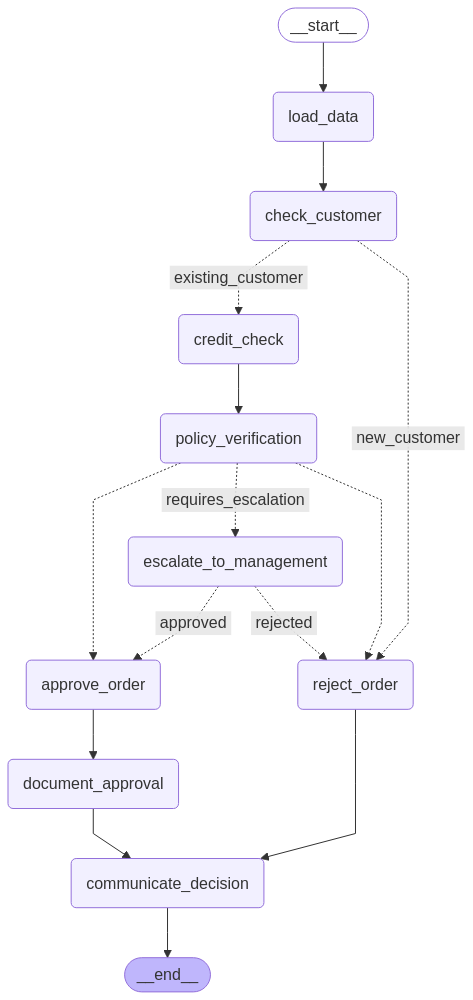

In [43]:
from IPython.display import Image

Image(ar_workflow.get_graph().draw_mermaid_png())

In [ ]:
# print("Starting workflow...")
# result = ar_workflow.invoke({
#     "customer_data": {},
#     "order_data": {},
#     "policy_content": load_policy(),
#     "credit_assessment": {},
#     "approval_status": "",
#     "decision_reason": "",
#     "requires_human": False,
#     "customer_exists": True  # Set to True to test the main path
# })
# print("Workflow complete.")

Starting workflow...
Loaded data for customer: C001
Checking if customer C001 exists: True

STARTING CREDIT ASSESSMENT
Customer data keys: ['Customer_ID', 'Customer_Name', 'Credit_Limit', 'Outstanding_Balance', 'Credit_Score', 'Payment_Terms', 'Customer_Status']
Order data keys: ['Order_ID', 'Customer_ID', 'Order_Date', 'turnover', 'Status', 'Payment_Method']
Parsed values: Credit Limit=$100000.0, Outstanding=$20000.0, Order=$15000.0

Preparing LLM prompt...
Sending request to Gemini...


SENDING PROMPT TO GEMINI:
Human: 
        Your a CA in accounts receivable team and you are working for a credit risk management team,.
        You are responsible for assessing the creditworthiness of customers based on company policy and customers credit limit, outstanding balance, and order amount.
        You have access to a credit policy document that outlines the criteria for credit approval: 
        Policy: # Credit Policy Document

## 1. **Purpose**
To establish guidelines for evaluating, ap

In [49]:
customer_master_json = [
  {
    "Customer_ID": "C001",
    "Customer_Name": "ABC Corp",
    "Credit_Limit": 100000,
    "Outstanding_Balance": 20000,
    "Credit_Score": 750,
    "Payment_Terms": "Net 30",
    "Customer_Status": "Active"
  },
  {
    "Customer_ID": "C002",
    "Customer_Name": "XYZ Ltd",
    "Credit_Limit": 50000,
    "Outstanding_Balance": 45000,
    "Credit_Score": 680,
    "Payment_Terms": "Net 45",
    "Customer_Status": "Active"
  },
  {
    "Customer_ID": "C003",
    "Customer_Name": "Global Enterprises",
    "Credit_Limit": 200000,
    "Outstanding_Balance": 150000,
    "Credit_Score": 820,
    "Payment_Terms": "Net 30",
    "Customer_Status": "Active"
  },
  {
    "Customer_ID": "C004",
    "Customer_Name": "Small Business Inc",
    "Credit_Limit": 25000,
    "Outstanding_Balance": 10000,
    "Credit_Score": 620,
    "Payment_Terms": "Net 15",
    "Customer_Status": "Warning"
  },
  {
    "Customer_ID": "C005",
    "Customer_Name": "Late Payer LLC",
    "Credit_Limit": 75000,
    "Outstanding_Balance": 70000,
    "Credit_Score": 600,
    "Payment_Terms": "Net 30",
    "Customer_Status": "Warning"
  }
]


In [50]:
sales_order_json = [
  {
    "Order_ID": "O001",
    "Customer_ID": "C001",
    "Order_Date": "2025-04-20",
    "turnover": 15000,
    "Status": "Pending",
    "Payment_Method": "Credit"
  },
  {
    "Order_ID": "O002",
    "Customer_ID": "C002",
    "Order_Date": "2025-04-22",
    "turnover": 10000,
    "Status": "Pending",
    "Payment_Method": "Credit"
  },
  {
    "Order_ID": "O003",
    "Customer_ID": "C003",
    "Order_Date": "2025-04-23",
    "turnover": 50000,
    "Status": "Pending",
    "Payment_Method": "Credit"
  },
  {
    "Order_ID": "O004",
    "Customer_ID": "C004",
    "Order_Date": "2025-04-25",
    "turnover": 18000,
    "Status": "Pending",
    "Payment_Method": "Credit"
  },
  {
    "Order_ID": "O005",
    "Customer_ID": "C005",
    "Order_Date": "2025-04-26",
    "turnover": 15000,
    "Status": "Pending",
    "Payment_Method": "Credit"
  },
  {
    "Order_ID": "O006",
    "Customer_ID": "C999",
    "Order_Date": "2025-04-27",
    "turnover": 5000,
    "Status": "Pending",
    "Payment_Method": "Credit"
  }
]


In [ ]:
# test_ar_workflow.py

import json
import os
import unittest
from unittest.mock import patch, MagicMock
import pandas as pd
from datetime import datetime

# Import the module to test
from main import (
    load_policy, 
    data_loader, 
    check_customer_data, 
    credit_assessment,
    policy_check, 
    approve_order, 
    reject_order, 
    human_escalation,
    document_approval, 
    communicate_decision,
    ARWorkflowState,
    ar_workflow
)

# Mock LLM response class
class MockGeminiResponse:
    """Mock response object for Gemini LLM"""
    def __init__(self, content):
        self.content = content
        self.generations = [[MagicMock(text=content)]]

class TestARWorkflow(unittest.TestCase):
    """Test suite for Accounts Receivable Workflow"""
    
    def setUp(self):
        """Set up test environment with sample data"""
        # Create temporary files for test data
        self.temp_files = []
        
        # Create customer master CSV
        with open('customer_master.json', 'r') as f:
            customer_data = json.load(f)
        self.customer_df = pd.DataFrame(customer_data)
        self.customer_df.to_csv('customer_master.csv', index=False)
        self.temp_files.append('customer_master.csv')
        
        # Create sales order CSV
        with open('sales_order.json', 'r') as f:
            order_data = json.load(f)
        self.order_df = pd.DataFrame(order_data)
        self.order_df.to_csv('sales_order.csv', index=False)
        self.temp_files.append('sales_order.csv')
        
        # Create credit policy file
        with open('CreditPolicy.txt', 'r') as f:
            policy_content = f.read()
        
        # Create base state for testing
        self.base_state = {
            "customer_data": {},
            "order_data": {},
            "policy_content": "",
            "credit_assessment": {},
            "approval_status": "",
            "decision_reason": "",
            "requires_human": False,
            "customer_exists": True
        }
    
    def tearDown(self):
        """Clean up temporary files"""
        for file in self.temp_files:
            if os.path.exists(file):
                os.remove(file)
    
    def test_load_policy(self):
        """Test loading of credit policy"""
        policy = load_policy()
        self.assertIsNotNone(policy)
        self.assertIn("COMPANY CREDIT POLICY", policy)
    
    def test_data_loader(self):
        """Test loading customer and order data"""
        state = data_loader(self.base_state)
        
        # Verify customer data was loaded
        self.assertIn("Customer_ID", state["customer_data"])
        self.assertIn("Credit_Limit", state["customer_data"])
        
        # Verify order data was loaded
        self.assertIn("Order_ID", state["order_data"])
        self.assertIn("turnover", state["order_data"])
        
        # Verify policy was loaded
        self.assertIn("COMPANY CREDIT POLICY", state["policy_content"])
    
    def test_check_customer_data_existing(self):
        """Test customer verification with existing customer"""
        state = self.base_state.copy()
        state["order_data"] = {"Customer_ID": "C001"}
        
        result = check_customer_data(state)
        self.assertTrue(result["customer_exists"])
    
    def test_check_customer_data_nonexisting(self):
        """Test customer verification with non-existing customer"""
        state = self.base_state.copy()
        state["order_data"] = {"Customer_ID": "NONEXISTENT"}
        
        result = check_customer_data(state)
        self.assertFalse(result["customer_exists"])
    
    @patch('main.ChatGoogleGenerativeAI')
    def test_credit_assessment_within_limits(self, mock_llm):
        """Test credit assessment with order within limits"""
        # Mock LLM response
        mock_response = MagicMock()
        mock_response.content = """
        ANALYSIS: Customer has good credit history and sufficient available credit.
        WITHIN_LIMITS: Yes
        NEEDS_ESCALATION: No
        """
        mock_llm.return_value.invoke.return_value = mock_response
        
        # Create test state
        state = self.base_state.copy()
        state["customer_data"] = {
            "Customer_ID": "C001",
            "Credit_Limit": 100000,
            "Outstanding_Balance": 20000
        }
        state["order_data"] = {
            "turnover": 15000
        }
        state["policy_content"] = "Test policy content"
        
        result = credit_assessment(state)
        
        # Verify assessment details
        self.assertIn("analysis", result["credit_assessment"])
        self.assertEqual(result["credit_assessment"]["available_credit"], 80000)
        self.assertEqual(result["credit_assessment"]["order_amount"], 15000)
        self.assertTrue(result["credit_assessment"]["within_limits"])
        self.assertFalse(result["credit_assessment"]["needs_escalation"])
    
    def test_policy_check_approved(self):
        """Test policy check for order that should be approved"""
        state = self.base_state.copy()
        state["credit_assessment"] = {
            "analysis": "Good credit history",
            "available_credit": 80000,
            "order_amount": 15000,
            "within_limits": True,
            "needs_escalation": False
        }
        
        result = policy_check(state)
        
        self.assertEqual(result["approval_status"], "approved")
        self.assertIn("within credit limits", result["decision_reason"])
        self.assertFalse(result["requires_human"])
    
    def test_policy_check_rejected(self):
        """Test policy check for order that should be rejected"""
        state = self.base_state.copy()
        state["credit_assessment"] = {
            "analysis": "Exceeds credit limits",
            "available_credit": 5000,
            "order_amount": 10000,
            "within_limits": False,
            "needs_escalation": True
        }
        
        result = policy_check(state)
        
        self.assertEqual(result["approval_status"], "rejected")
        self.assertIn("exceeds available credit", result["decision_reason"])
        self.assertTrue(result["requires_human"])
    
    def test_approve_order(self):
        """Test order approval process"""
        state = self.base_state.copy()
        result = approve_order(state)
        
        self.assertEqual(result["approval_status"], "approved")
        self.assertIn("approved", result["decision_reason"])
    
    def test_reject_order(self):
        """Test order rejection process"""
        state = self.base_state.copy()
        state["decision_reason"] = "Exceeds credit limits"
        result = reject_order(state)
        
        self.assertEqual(result["approval_status"], "rejected")
        self.assertEqual(result["decision_reason"], "Exceeds credit limits")
    
    def test_document_approval(self):
        """Test documentation of approval decision"""
        state = self.base_state.copy()
        result = document_approval(state)
        
        self.assertTrue(result["documentation_complete"])
        self.assertIn("documentation_timestamp", result)
    
    def test_communicate_decision(self):
        """Test communication of decision"""
        state = self.base_state.copy()
        result = communicate_decision(state)
        
        self.assertTrue(result["communication_complete"])
        self.assertTrue(result["notification_sent"])
    
    def test_batch_processing_scenarios(self):
        """Test multiple credit scenarios in batch"""
        test_scenarios = [
            {
                "description": "Clearly within limits",
                "customer": {"Customer_ID": "C001", "Credit_Limit": 100000, "Outstanding_Balance": 20000},
                "order": {"turnover": 15000},
                "expected_result": "approved"
            },
            {
                "description": "Exactly at limit",
                "customer": {"Customer_ID": "C003", "Credit_Limit": 200000, "Outstanding_Balance": 150000},
                "order": {"turnover": 50000},
                "expected_result": "approved"
            },
            {
                "description": "Slightly over limit",
                "customer": {"Customer_ID": "C002", "Credit_Limit": 50000, "Outstanding_Balance": 45000},
                "order": {"turnover": 10000},
                "expected_result": "rejected"
            },
            {
                "description": "Far exceeding limit",
                "customer": {"Customer_ID": "C004", "Credit_Limit": 25000, "Outstanding_Balance": 10000},
                "order": {"turnover": 40000},
                "expected_result": "rejected"
            },
            {
                "description": "At risk customer",
                "customer": {"Customer_ID": "C005", "Credit_Limit": 75000, "Outstanding_Balance": 70000},
                "order": {"turnover": 4000},
                "expected_result": "approved"
            }
        ]
        
        # Test each scenario
        for scenario in test_scenarios:
            with self.subTest(scenario=scenario["description"]):
                # Setup state for this scenario
                state = self.base_state.copy()
                state["customer_data"] = scenario["customer"]
                state["order_data"] = scenario["order"]
                state["policy_content"] = load_policy()
                
                # Mock LLM to return appropriate response
                with patch('main.ChatGoogleGenerativeAI') as mock_llm:
                    mock_response = MagicMock()
                    
                    # Set within_limits based on expected result
                    within_limits = "Yes" if scenario["expected_result"] == "approved" else "No"
                    
                    mock_response.content = f"""
                    ANALYSIS: Test {scenario["description"]}
                    WITHIN_LIMITS: {within_limits}
                    NEEDS_ESCALATION: No
                    """
                    mock_llm.return_value.invoke.return_value = mock_response
                    
                    # Run credit assessment and policy check
                    assessed_state = credit_assessment(state)
                    final_state = policy_check(assessed_state)
                    
                    # Verify results
                    self.assertEqual(
                        final_state["approval_status"], 
                        scenario["expected_result"],
                        f"Failed for scenario: {scenario['description']}"
                    )
    
    @patch('main.interrupt')
    def test_human_escalation_approval(self, mock_interrupt):
        """Test human escalation with approval decision"""
        # Mock approval decision
        mock_interrupt.return_value = "approved"
        
        state = self.base_state.copy()
        state["customer_data"] = {"Customer_ID": "C001", "Credit_Limit": 100000, "Outstanding_Balance": 20000}
        state["order_data"] = {"turnover": 15000}
        state["decision_reason"] = "Requires management review"
        
        result = human_escalation(state)
        
        self.assertEqual(result["approval_status"], "approved")
        self.assertIn("management", result["decision_reason"])
    
    @patch('main.interrupt')
    @patch('main.ChatGoogleGenerativeAI')
    def test_full_workflow_simulation(self, mock_llm, mock_interrupt):
        """Test a complete simulation of the AR workflow with multiple scenarios"""
        
        test_scenarios = [
            {
                "description": "Standard approval",
                "customer_id": "C001",
                "order_amount": 15000,
                "llm_response": """
                    ANALYSIS: Customer has excellent credit history and sufficient available credit.
                    WITHIN_LIMITS: Yes
                    NEEDS_ESCALATION: No
                """,
                "expected_status": "approved",
                "needs_escalation": False
            },
            {
                "description": "Automatic rejection",
                "customer_id": "C002",
                "order_amount": 10000,  # Exceeds available credit
                "llm_response": """
                    ANALYSIS: Order exceeds available credit.
                    WITHIN_LIMITS: No
                    NEEDS_ESCALATION: No
                """,
                "expected_status": "rejected",
                "needs_escalation": False
            },
            {
                "description": "Management approval after escalation",
                "customer_id": "C005",
                "order_amount": 5000,
                "llm_response": """
                    ANALYSIS: Customer is close to credit limit. Management review needed.
                    WITHIN_LIMITS: Yes
                    NEEDS_ESCALATION: Yes
                """,
                "expected_status": "approved",
                "needs_escalation": True,
                "management_decision": "approved"
            }
        ]
        
        for scenario in test_scenarios:
            with self.subTest(scenario=scenario["description"]):
                # Set up mock LLM response
                mock_response = MagicMock()
                mock_response.content = scenario["llm_response"]
                mock_llm.return_value.invoke.return_value = mock_response
                
                # Set up mock management decision if needed
                if scenario.get("needs_escalation", False):
                    mock_interrupt.return_value = scenario["management_decision"]
                
                # Create initial state
                initial_state = {
                    "customer_data": {},
                    "order_data": {},
                    "policy_content": load_policy(),
                    "credit_assessment": {},
                    "approval_status": "",
                    "decision_reason": "",
                    "requires_human": False,
                    "customer_exists": True
                }
                
                # Override customer_data and order_data in data_loader
                with patch('main.pd.read_csv') as mock_read_csv:
                    # Create specific customers and orders for this test
                    customer_with_id = self.customer_df[self.customer_df['Customer_ID'] == scenario["customer_id"]]
                    order_with_amount = self.order_df.copy()
                    order_with_amount.loc[0, 'turnover'] = scenario["order_amount"]
                    order_with_amount.loc[0, 'Customer_ID'] = scenario["customer_id"]
                    
                    # Mock read_csv to return our test data
                    mock_read_csv.side_effect = lambda filename: (
                        customer_with_id if 'customer_master.csv' in filename else order_with_amount
                    )
                    
                    # Run the workflow
                    result = ar_workflow.invoke(initial_state)
                    
                    # Verify final state
                    self.assertEqual(
                        result["approval_status"], 
                        scenario["expected_status"],
                        f"Failed for scenario: {scenario['description']}"
                    )
                    self.assertTrue(result["communication_complete"])

if __name__ == '__main__':
    unittest.main()
